# Two-Asset Model

**Table of contents**<a id='toc0_'></a>    
- 1. [Model class](#toc1_)    
  - 1.1. [Utility function and derivatives](#toc1_1_)    
- 2. [Final period](#toc2_)    
  - 2.1. [Post-decision](#toc2_1_)    
  - 2.2. [Solve](#toc2_2_)    
  - 2.3. [Owner behavior](#toc2_3_)    
- 3. [First period](#toc3_)    
  - 3.1. [Post-decision](#toc3_1_)    
  - 3.2. [Generate points](#toc3_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

import quantecon as qe

from EconModel import EconModelClass, jit

from consav.grids import equilogspace
from consav.linear_interp import interp_1d
from consav import upperenvelope

## 1. <a id='toc1_'></a>[Model class](#toc0_)

In [2]:
class IlliquidAssetModelClass(EconModelClass):

    def settings(self):

        pass

    def setup(self):

        par = self.par

        # a. preferences
        par.beta = 0.90 # discount factor
        par.sigma = 2.0 # CRRA coefficient

        # b. return
        par.k = 1.0 # size of illiquid asset
        par.gamma = 0.20 # preaccess penalty

        # c. income
        par.y = np.array([1.0]) # income values
        par.w_y = np.array([1.0]) # income probabilities
        
        # c. grids
        par.Nm = 1000 # number of grid points
        par.m_max = 5.0 # maximum value of m

        par.Na = 2000 # number of grid points
        par.a_max = 3.0 # maximum value of a

    def allocate(self):

        par = self.par
        sol = self.sol

        # a. grids
        m_min = 1e-1 # just some low value < y.min()
        par.m_grid = equilogspace(m_min,par.m_max,par.Nm)
        a_min = 0.0 # no borrowing
        par.a_grid = equilogspace(a_min,par.a_max,par.Na)

        par.Ny = par.y.size # number of income states

        # b. solution
        sol.w = np.zeros((2,2,par.Na))
        sol.q = np.zeros((2,2,par.Na))

        sol.m_endo = np.zeros((2,2,par.Na))
        sol.c_endo = np.zeros((2,2,par.Na))
        
        sol.v = np.zeros((2,2,par.Nm))
        sol.c = np.zeros((2,2,par.Nm))

In [3]:
model = IlliquidAssetModelClass(name='vfi')

In [4]:
par = model.par
sol = model.sol

### 1.1. <a id='toc1_1_'></a>[Utility function and derivatives](#toc0_)

In [5]:
@nb.njit
def u_func(c,par):
    return c**(1-par.sigma)/(1-par.sigma)

@nb.njit
def marg_u_func(c,par):
    return c**(-par.sigma)

@nb.njit
def inv_marg_u_func(c,par):
    return c**(-1/par.sigma)

## 2. <a id='toc2_'></a>[Final period](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Post-decision](#toc0_)

In [6]:
@nb.njit
def compute_wq(par,sol,t):
    
    for own in range(2):
        for i_a in range(par.Na):

            a = par.a_grid[i_a]

            sol.w[t,own,i_a] = 0.0
            sol.q[t,own,i_a] = 0.0

            # weigted accumulation over next period income
            for i_y_plus in range(par.Ny):

                y = par.y[i_y_plus]
                w_y = par.w_y[i_y_plus]

                # cash-on-hand
                m_plus = a + y

                if t == 1: # consume all in last period

                    c_plus = m_plus
                    if own: c_plus += par.k

                    v_plus = u_func(c_plus,par)
                    sol.w[t,own,i_a] += w_y*v_plus

                    marg_u_plus = marg_u_func(c_plus,par)
                    sol.q[t,own,i_a] += w_y*marg_u_plus

                else:
                    
                    # value of keeping
                    v_plus_keep = interp_1d(par.m_grid,sol.v[t+1,own],m_plus)

                    # value of selling (if owning)
                    m_plus_sell = m_plus + (1-par.gamma)*par.k
                    v_plus_sell = interp_1d(par.m_grid,sol.v[t+1,0],m_plus_sell) if own == 1 else -np.inf

                    # best
                    if v_plus_keep > v_plus_sell:
                        v_plus = v_plus_keep
                        c_plus = interp_1d(par.m_grid,sol.c[t+1,own],m_plus)
                    else:
                        v_plus = v_plus_sell
                        c_plus = interp_1d(par.m_grid,sol.c[t+1,0],m_plus_sell)

                    # accumulate
                    sol.w[t,own,i_a] += w_y*v_plus
                    
                    marg_u_plus = marg_u_func(c_plus,par)
                    sol.q[t,own,i_a] += w_y*marg_u_plus

In [7]:
with jit(model):
    compute_wq(model.par,model.sol,1)

In [8]:
def plot_wq(par,sol,t):

    fig = plt.figure(figsize=(12,4))
                    
    ax = fig.add_subplot(1,2,1)
    ax.set_title('post-decision value')

    for own in [0,1]:
        ax.plot(par.a_grid,sol.w[t,own,:],label=f'{own = }')

    ax.set_xlabel('$a_t$')
    ax.legend()
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title('post-decision marginal value')
    for own in [0,1]:
        ax.plot(par.a_grid,sol.q[t,own,:])

    ax.set_xlabel('$a_t$')
    fig.tight_layout()

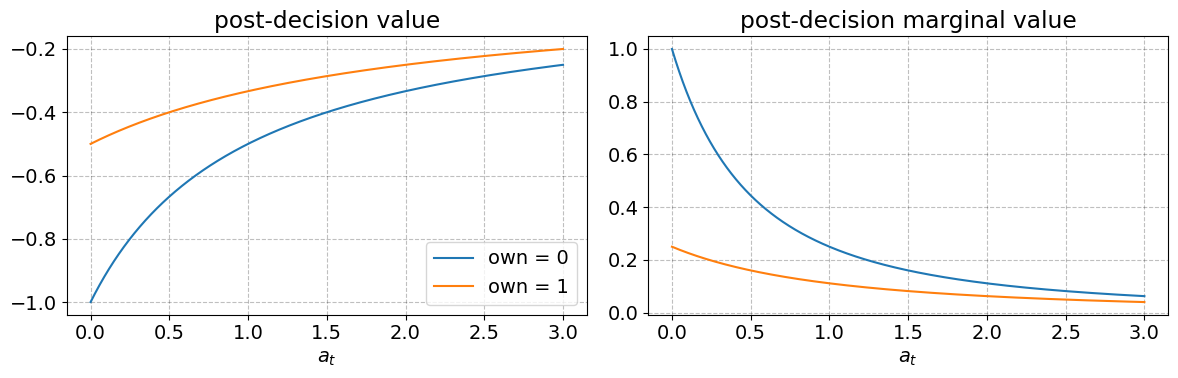

In [9]:
plot_wq(par,sol,1)

### 2.2. <a id='toc2_2_'></a>[Solve](#toc0_)

In [10]:
@nb.njit
def generate_points(par,sol,t):

    for own in range(2):

        # a. invert Euler-equation
        sol.c_endo[t,own,:] = inv_marg_u_func(par.beta*sol.q[t,own,:],par)

        # b. endogenous cash-on-hand
        sol.m_endo[t,own,:] = par.a_grid + sol.c_endo[t,own,:]

@nb.njit
def solve(par,sol,t):

    for own in range(2):
        for i_m in range(par.Nm):

            m = par.m_grid[i_m]

            # a. consumption
            if m < sol.m_endo[t,own,0]: # borrowing constraint
                sol.c[t,own,i_m] = m
            else: # re-interpolate to common grid
                sol.c[t,own,i_m] = interp_1d(sol.m_endo[t,own,:],sol.c_endo[t,own,:],m) 

            # b. implied value
            a = m - sol.c[t,own,i_m]
            w_interp = interp_1d(par.a_grid,sol.w[t,own,:],a)
            sol.v[t,own,i_m] = u_func(sol.c[t,own,i_m],par) + par.beta*w_interp            

In [11]:
with jit(model):
    generate_points(model.par,model.sol,1)
    solve(model.par,model.sol,1)

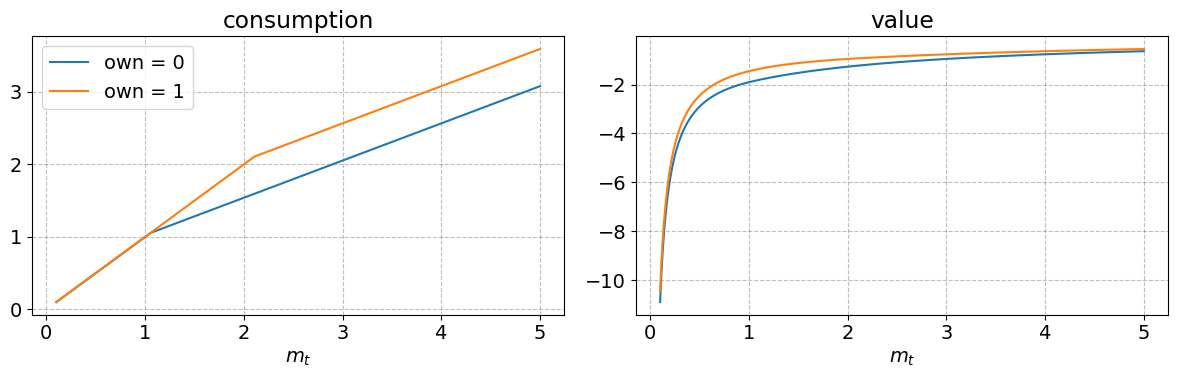

In [12]:
def plot_solve(par,sol,t):

    fig = plt.figure(figsize=(12,4))
                    
    ax = fig.add_subplot(1,2,1)
    ax.set_title('consumption')
    for own in [0,1]:
        ax.plot(par.m_grid,sol.c[t,own,:],label=f'{own = }')
    ax.set_xlabel('$m_t$')
    ax.legend(frameon=True)

    ax = fig.add_subplot(1,2,2)
    ax.set_title('value')
    for own in [0,1]:
        ax.plot(par.m_grid,sol.v[t,own,:],label=f'{own = }')
    ax.set_xlabel('$m_t$')

    fig.tight_layout()

plot_solve(par,sol,1)

### 2.3. <a id='toc2_3_'></a>[Owner behavior](#toc0_)

In [13]:
def owner_behavior(par,sol,t):
    
    # a. keep
    v_keep = sol.v[t,1]
    c_keep = sol.c[t,1]

    # b. sell
    v_sell = np.zeros(par.Nm)
    c_sell = np.zeros(par.Nm)

    for i_m in range(par.Nm):

        m = par.m_grid[i_m]
        m_sell = m + (1-par.gamma)*par.k
        
        v_sell[i_m] = interp_1d(par.m_grid,sol.v[t,0],m_sell)
        c_sell[i_m] = interp_1d(par.m_grid,sol.c[t,0],m_sell)

    # c. plot
    fig = plt.figure(figsize=(12,12))
                 
    ax = fig.add_subplot(3,2,1)
    ax.set_title('value')
    ax.plot(par.m_grid,v_keep,label='keep')
    ax.plot(par.m_grid,v_sell,label='sell')
    ax.set_xlabel('$m_t$')
    ax.legend(frameon=True)

    ax = fig.add_subplot(3,2,2)
    ax.set_title('sell or not')
    I = v_sell > v_keep
    ax.plot(par.m_grid,I)
    ax.set_xlabel('$m_t$')

    ax = fig.add_subplot(3,2,3)
    ax.set_title('choice-specific consumption')
    ax.plot(par.m_grid,c_keep,label='keep')
    ax.plot(par.m_grid,c_sell,label='sell')
    ax.set_xlabel('$m_t$')
    ax.legend()

    ax = fig.add_subplot(3,2,4)
    ax.set_title('consumption')
    c = c_keep.copy()
    c[I] = c_sell[I]
    ax.plot(par.m_grid,c)    
    ax.set_xlabel('$m_t$')

    ax = fig.add_subplot(3,2,5)
    ax.set_title('savings')
    a = par.m_grid-c_keep
    a[I] = par.m_grid[I]-c_sell[I] +(1-par.gamma)*par.k
    ax.plot(par.m_grid,a)    
    ax.set_xlabel('$m_t$')

    ax = fig.add_subplot(3,2,5)
    ax.set_title('savings')
    a = par.m_grid-c_keep
    a[I] = par.m_grid[I]-c_sell[I] +(1-par.gamma)*par.k
    ax.plot(par.m_grid,a)    
    ax.set_xlabel('$m_t$')    

    fig.tight_layout()

**Selling:**

1. Pro: Access to liquid now. Higher consumption today. Especially good if borrowing constrained.
1. Con: Lower consumption tomorrow. Especially due to the preaccess penalty, $\gamma$.

**Optimal behavior:**

1. If sell: High consumption today, low consumption tomorrow.
1. If keep: Low consumption today, high consumption tomorrow.

Implied: Downwards jump in consumption when rich enough don't to sell.

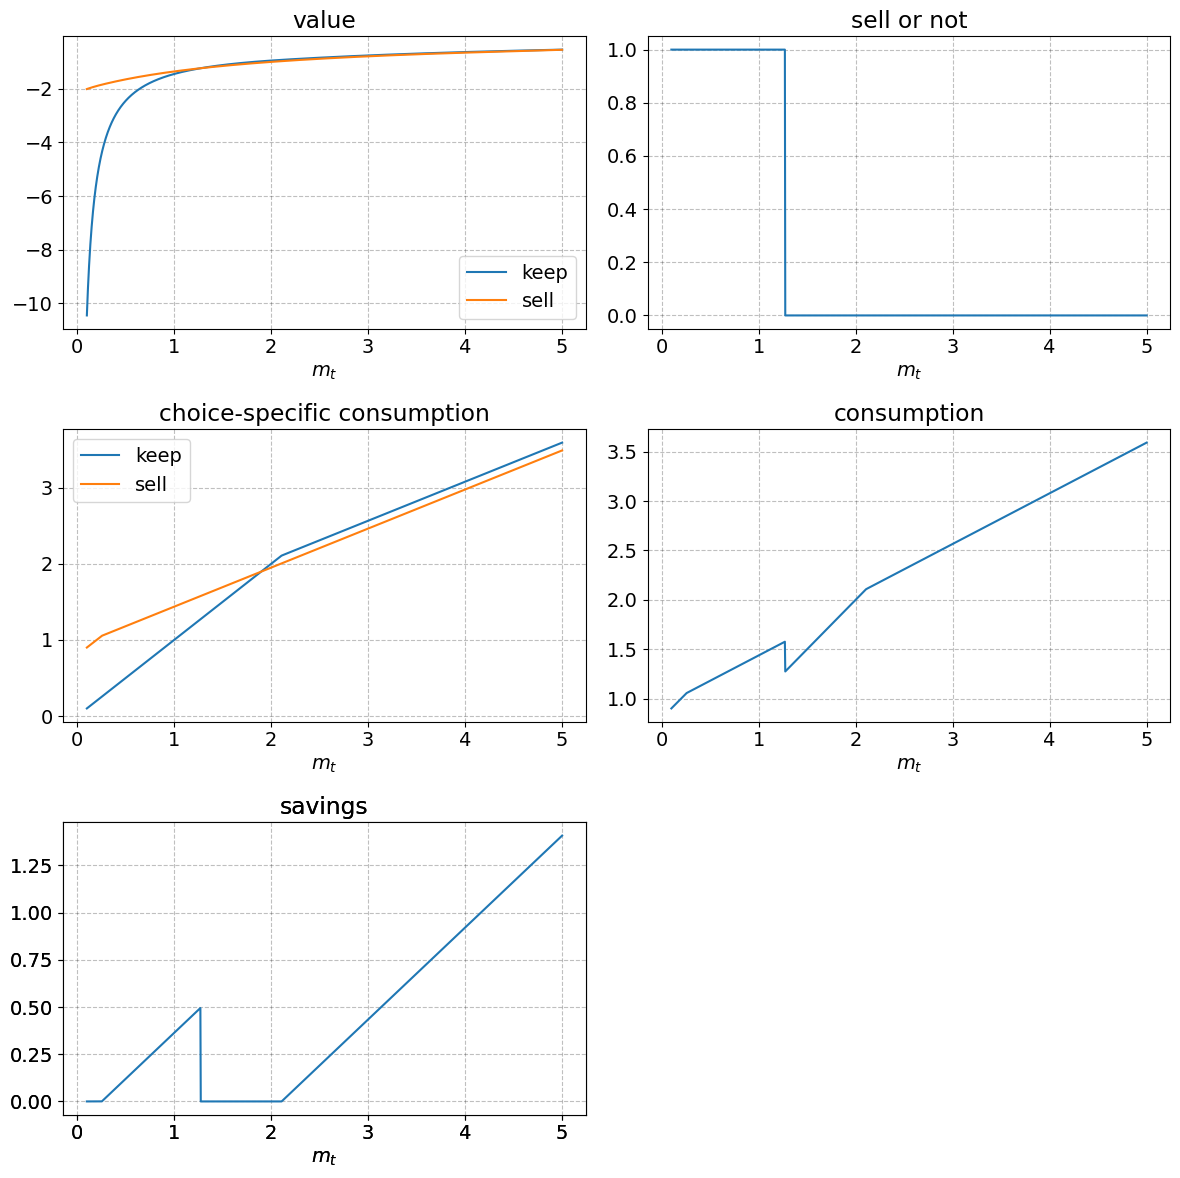

In [14]:
owner_behavior(par,sol,1)

* **Poor hand-to-mouth households**: Seller with no ex post savings.
* **Wealthy hand-to-mouth households**: Keeper with no savings.

(Note: More complicated dynamics if the illiquid asset is not accessible tomorrow and can also be invested in.)

## 3. <a id='toc3_'></a>[First period](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Post-decision](#toc0_)

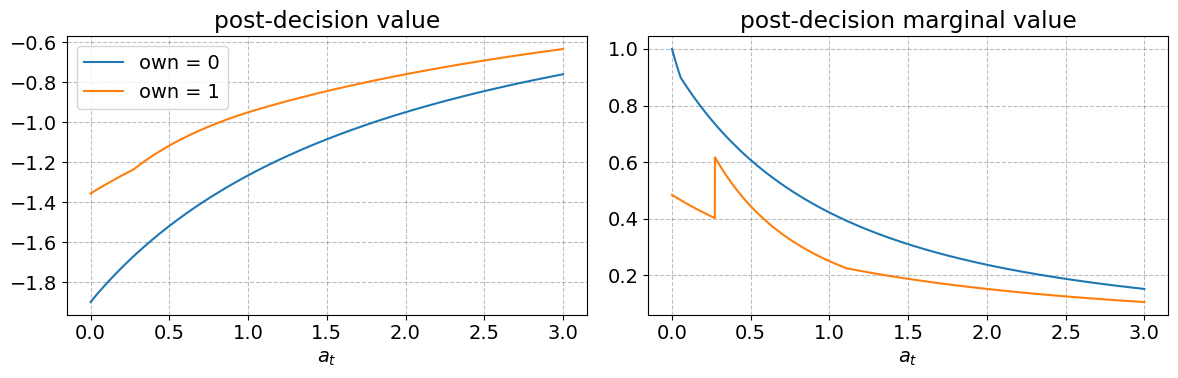

In [15]:
with jit(model):
    compute_wq(model.par,model.sol,0)

plot_wq(par,sol,0)

### 3.2. <a id='toc3_2_'></a>[Generate points](#toc0_)

In [16]:
with jit(model):
    generate_points(model.par,model.sol,0)

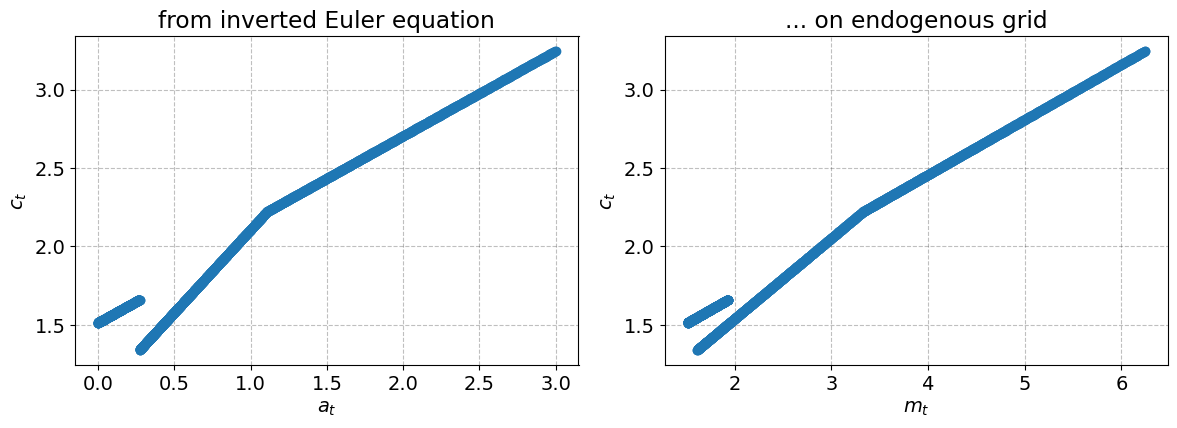

In [17]:
fig = plt.figure(figsize=(12,8))
                 
ax = fig.add_subplot(2,2,1)
ax.set_title('from inverted Euler equation')
ax.plot(par.a_grid,sol.c_endo[0,1,:],'o')
ax.set_xlabel('$a_t$')
ax.set_ylabel('$c_t$')

ax = fig.add_subplot(2,2,2)
ax.set_title('... on endogenous grid')
ax.plot(sol.m_endo[0,1,:],sol.c_endo[0,1,:],'o')
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')

fig.tight_layout()

**Problem:** Not a well-defined consumption function when there are overlaps in $m_t$ (due to non-sufficiency of Euler-equation). 

**Solution:** Apply upper envelope

In [18]:
upperenvelope_func = upperenvelope.create(u_func) # where u is the utility function

@nb.njit
def solve_with_upper_envelope(par,sol,t):     

    for i_k in range(2):

        m_vec = sol.m_endo[t,i_k,:]
        c_vec = sol.c_endo[t,i_k,:]
        w_vec = sol.w[t,i_k,:]
        
        upperenvelope_func(
            par.a_grid,m_vec,c_vec,w_vec, # input
            par.m_grid,sol.c[t,i_k,:],sol.v[t,i_k,:], # output  
            par)

with jit(model):
    solve_with_upper_envelope(model.par,model.sol,0)  

Implied consumption and value function:

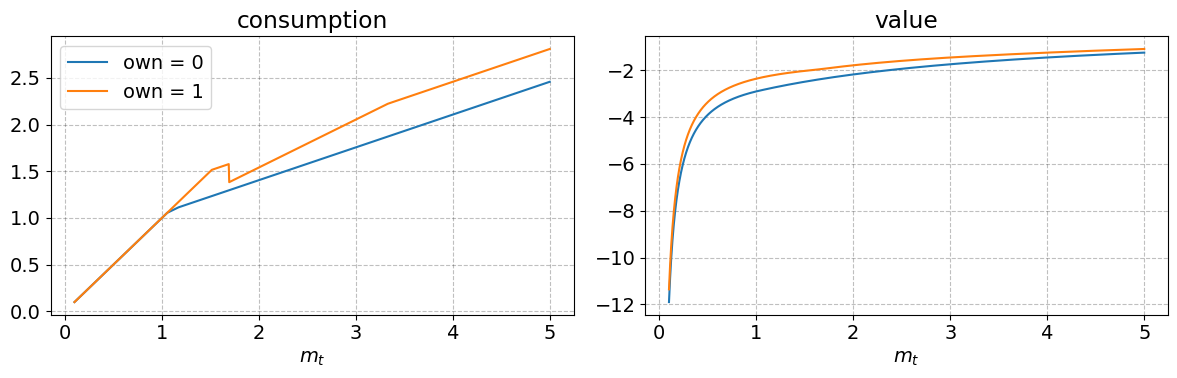

In [19]:
plot_solve(par,sol,0)

Owner behavior is now even more complicated:

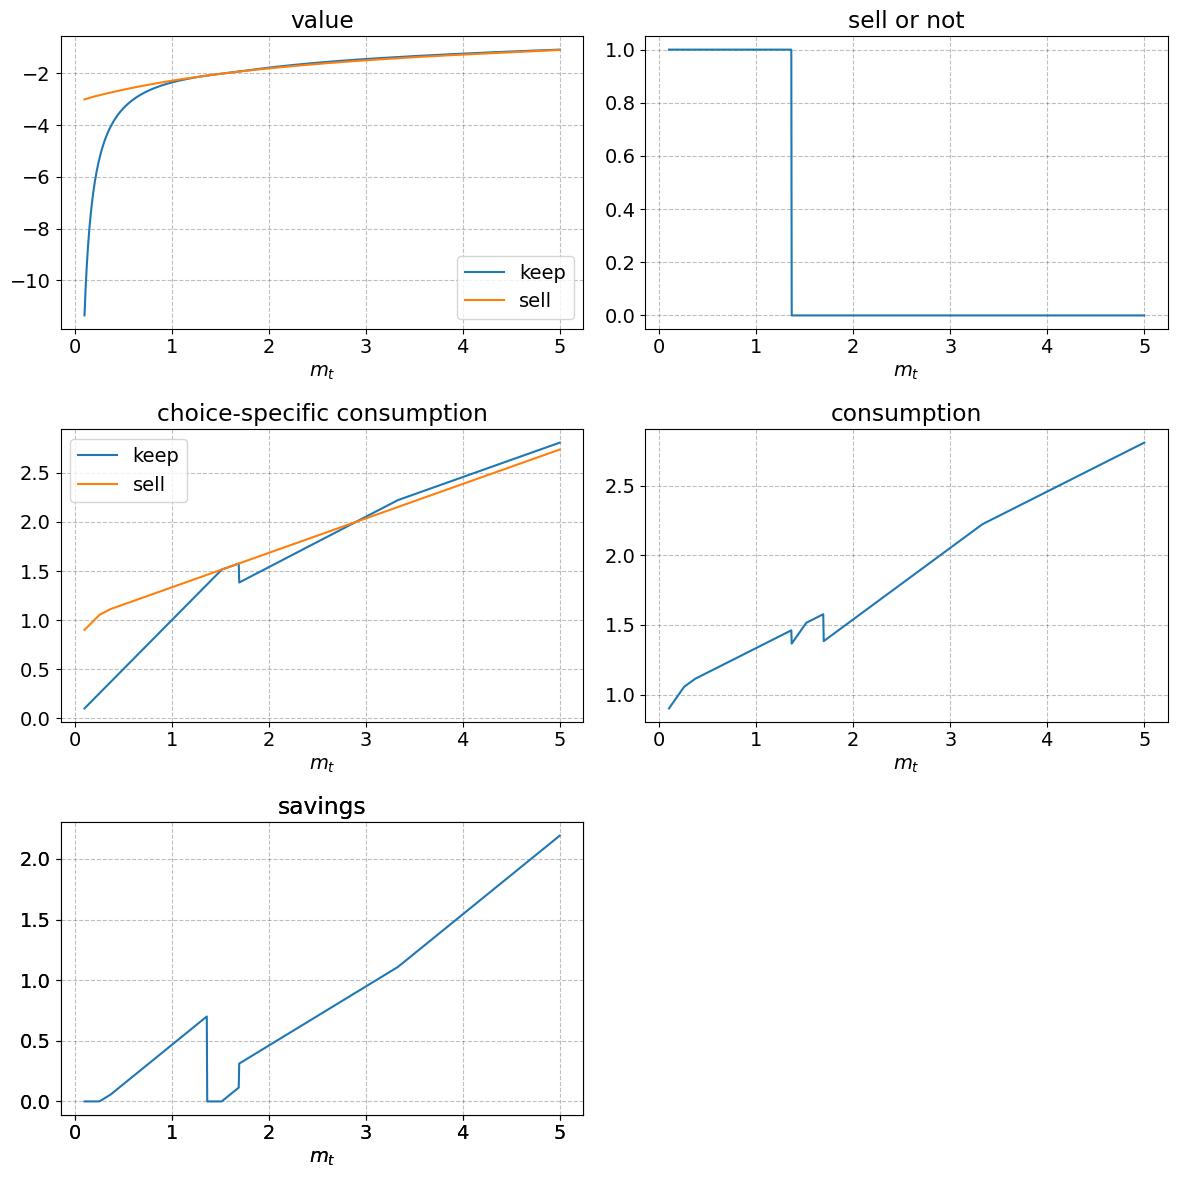

In [20]:
owner_behavior(par,sol,0)